In [ ]:
!pip install albumentations
# !pip install gdown

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/9b/f6/c486cedb4f75147232f32ec4c97026714cfef7c7e247a1f0427bc5489f66/albumentations-1.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-image>=0.16.1 from https://files.pythonhosted.org/packages/f1/6c/49f5a0ce8ddcdbdac5ac69c129654938cc6de0a936303caa6cad495ceb2a/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-python-headless>=4.1.1 from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for networkx>=2.8 from https://files.pythonhosted.org/packages/d5/f0/8fbc882ca80cf077f1b246c0e3c3465f7f415439bdea6b899f6b19f61f70/networkx-3

In [ ]:
import torch
from tqdm import tqdm
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
import torch
import os

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 4
NUM_EPOCHS = 50
NUM_WORKERS = 1
# CHECKPOINT_FILE = "1152KaggleBest.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = False
LOAD_MODEL = False
TRAIN_DIR = "Data/train"
VALID_DIR = "Data/val"
TEST_DIR = "Data/test"
IMAGE_SIZE = [2048,2048]

In [ ]:
class CCDataset(Dataset):
  def __init__(self, mode = 'train', augmentation=None):
    if mode == 'train':
      self.dataset_path = TRAIN_DIR
      ann_path = os.path.join(TRAIN_DIR, 'coco.json')
    if mode == 'valid':
      self.dataset_path = VALID_DIR
      ann_path = os.path.join(VALID_DIR, 'coco.json')
    if mode == 'test':
      self.dataset_path = TEST_DIR
      ann_path = os.path.join(TEST_DIR, 'coco.json')

    with open(ann_path, 'r') as file:
      coco_data = json.load(file)
      categories = coco_data['categories']

    # Create the mapping
    # self.id_to_seq_map = {cat['id']: i for i, cat in enumerate(categories)}
    self.id_to_seq_map = {}
    self.seq_to_name_map = {}
    for i, cat in enumerate(categories):
        self.id_to_seq_map[cat['id']] = i
        self.seq_to_name_map[i] = cat['name']

    self.coco = COCO(ann_path)
    self.cat_ids = self.coco.getCatIds()
    self.augmentation=augmentation
    self.img_ids = self.coco.getImgIds()

  def __len__(self):
      return len(self.img_ids)

  def get_masks(self, img_id):
    ann_ids = self.coco.getAnnIds(imgIds=[img_id])
    anns = self.coco.loadAnns(ann_ids)
    # print(f"Image ID: {img_id}, Annotation IDs: {ann_ids}")  # Debug line

    masks = []
    labels = []
    for ann in anns:
        mask = self.coco.annToMask(ann)
        # print(f"Mask shape for annotation {ann['id']}: {mask.shape}")  # Debug line
        if mask.sum() > 0:  # Check if the mask is not empty
            masks.append(mask)
            # Convert unique ID to sequential integer using the mapping
            seq_label = self.id_to_seq_map.get(ann['category_id'], 0)
            labels.append(seq_label)
            # print(f"Converted class label for image {img_id}: {seq_label}")
        # else:
        #     print(f"Empty mask for annotation {ann['id']}")  # Debug line

    return masks, labels

  def get_boxes(self, masks):
      num_objs = len(masks)
      boxes = []

      for i in range(num_objs):
          x,y,w,h = cv2.boundingRect(masks[i])
          boxes.append([x, y, x+w, y+h])

      return np.array(boxes)

  def __getitem__(self, index):
      # Load image
      img_id = self.img_ids[index]
      img_info = self.coco.loadImgs([img_id])[0]
      image = cv2.imread(os.path.join(self.dataset_path, 'images', img_info['file_name']))
      image_tensor = torch.as_tensor(image.transpose(2, 0, 1) / 255., dtype=torch.float32)  # Normalize and convert

      masks, class_labels = self.get_masks(img_id)

      if len(masks) > 0:
          masks_np = np.array(masks)
          boxes = self.get_boxes(masks_np)

          num_objs = len(masks)
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          labels = torch.as_tensor(class_labels, dtype=torch.int64)
          masks_tensor = torch.as_tensor(masks_np, dtype=torch.uint8)

          data = {"boxes": boxes, "labels": labels, "masks": masks_tensor}
      else:
          # print(f"No objects found for image ID {img_id}")
          data = {"boxes": torch.empty((0, 4), dtype=torch.float32),
                  "labels": torch.empty((0,), dtype=torch.int64),
                  "masks": torch.empty((0, image.shape[0], image.shape[1]), dtype=torch.uint8)}

      return image_tensor, data

In [ ]:
# To bypass shape errors
# Images contain different number of instances
def collate_fn(batch):
  images = list()
  targets = list()
  for b in batch:
        images.append(b[0])
        targets.append(b[1])
  images = torch.stack(images, dim=0)
  return images, targets

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
Sample 0:
Image shape: torch.Size([3, 2048, 2048])
Number of objects: 6


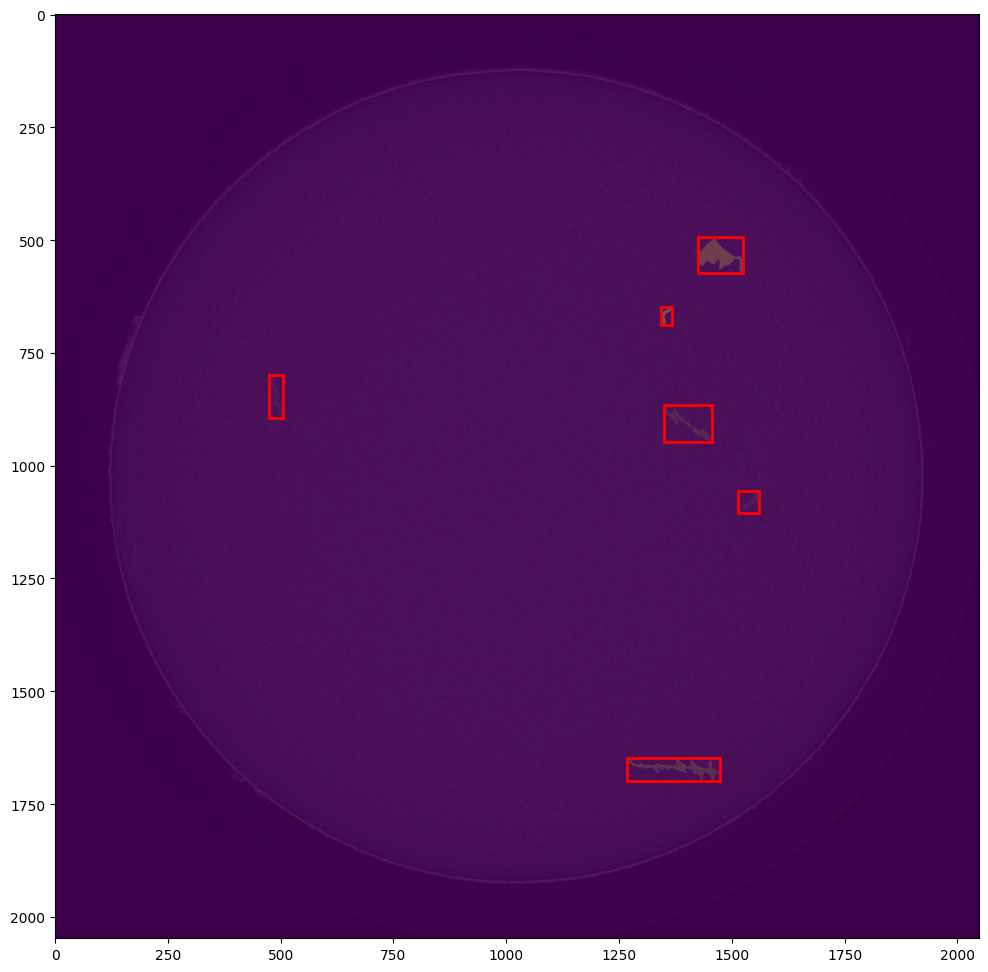

Sample 1:
Image shape: torch.Size([3, 2048, 2048])
Number of objects: 1


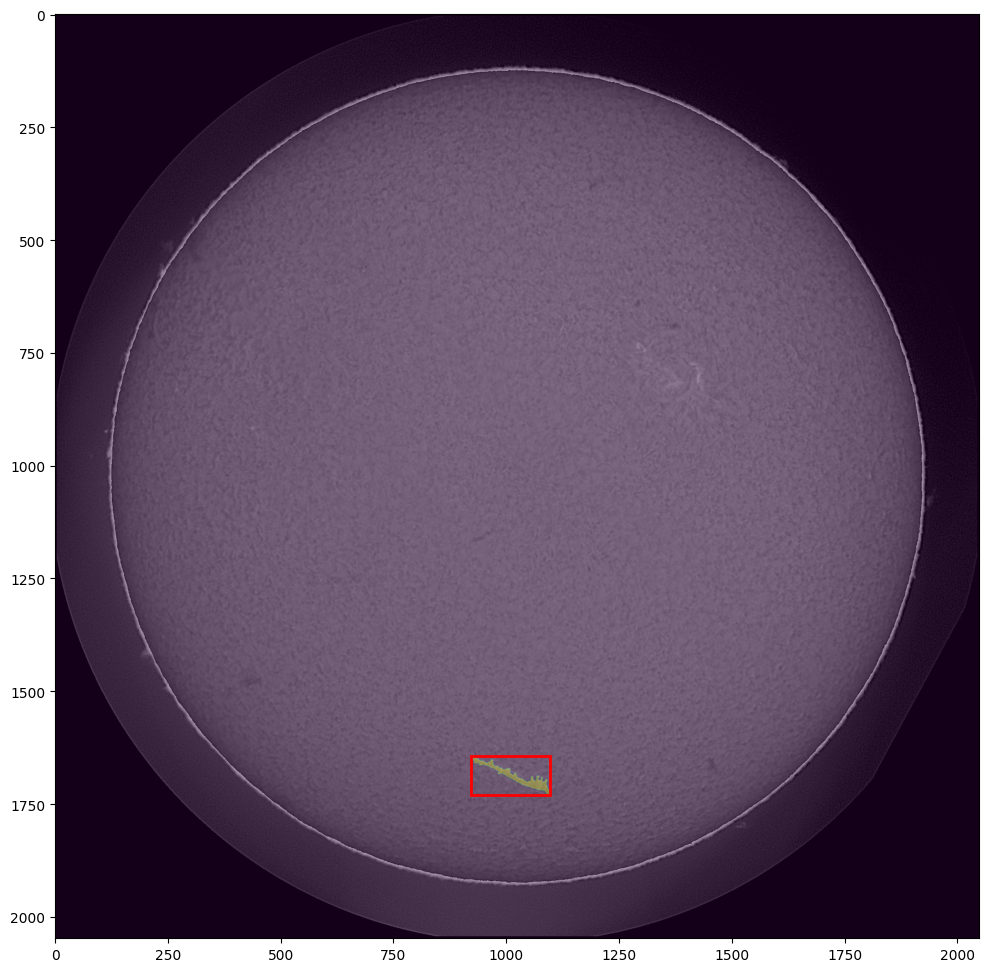

Sample 2:
Image shape: torch.Size([3, 2048, 2048])
Number of objects: 4


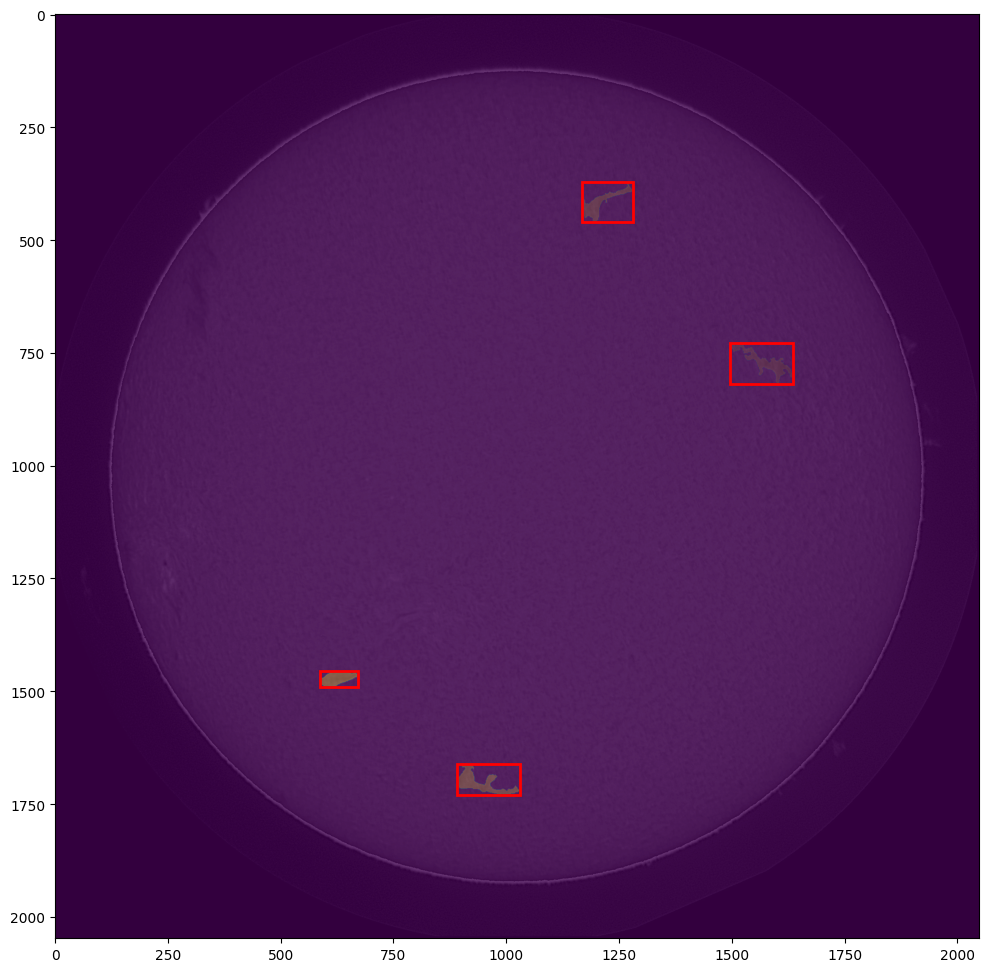

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_masks_and_boxes(image, masks, boxes, figsize=(12, 12)):
    """Display image with its masks and bounding boxes."""
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    for mask, box in zip(masks, boxes):
        # Create a Rectangle patch for the bounding box
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add mask
        ax.imshow(mask, alpha=0.3)

    plt.show()

def validate_dataset(dataset, num_samples=5):
    """Validate a few samples from the dataset."""
    for i in range(num_samples):
        image, data = dataset[i]
        print(f"Sample {i}:")
        print(f"Image shape: {image.shape}")
        print(f"Number of objects: {len(data['masks'])}")

        # Convert image from tensor to numpy array and denormalize
        image_np = image.numpy().transpose((1, 2, 0)) * 255
        image_np = image_np.astype('uint8')

        # Convert masks and boxes to numpy arrays
        masks_np = data['masks'].numpy()
        boxes_np = data['boxes'].numpy()

        # Display image with masks and boxes
        show_image_with_masks_and_boxes(image_np, masks_np, boxes_np)

# Example usage
train_dataset = CCDataset(mode='train')
validate_dataset(train_dataset, num_samples=3)

In [ ]:
import albumentations as A

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(
        contrast_limit=0.2, brightness_limit=0.3, p=0.5),
    A.OneOf([
        A.ImageCompression(p=0.8),
        A.RandomGamma(p=0.8),
        A.Blur(p=0.8),
        A.Equalize(mode='cv',p=0.8)
    ], p=1.0),
    A.OneOf([
        A.ImageCompression(p=0.8),
        A.RandomGamma(p=0.8),
        A.Blur(p=0.8),
        A.Equalize(mode='cv',p=0.8),
    ], p=1.0)
])

In [ ]:
def get_model():
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
            in_features, num_classes=1+4)
    model.to(DEVICE)
    return model

In [ ]:
def save_checkpoint(state, filename="mask_rcnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
if LOAD_MODEL and CHECKPOINT_FILE in os.listdir():
        print("Loading checkpoint")
        load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)

In [ ]:
train_dataset = CCDataset(mode='train', augmentation=None)
train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn)
seq_to_name_map = train_dataset.seq_to_name_map

valid_dataset = CCDataset(mode='valid')
valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
# def train_one_epoch(loader, model, optimizer, device):
#     loop = tqdm(loader)

#     for batch_idx, (images, targets) in enumerate(loop):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     print(f"Total loss: {losses.item()}")
#     return losses.item()

def train_one_epoch(loader, model, optimizer, device):
    model.train()
    loop = tqdm(loader)

    total_loss_accumulated = 0
    classification_loss_accumulated = 0
    box_loss_accumulated = 0
    mask_loss_accumulated = 0  # If applicable
    num_batches = len(loader)

    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        # Accumulate each loss component
        total_loss_accumulated += losses.item()
        classification_loss_accumulated += loss_dict.get('loss_classifier', 0).item()
        box_loss_accumulated += loss_dict.get('loss_box_reg', 0).item()
        mask_loss_accumulated += loss_dict.get('loss_mask', 0).item()  # If applicable

    # Calculate the average loss for each component
    avg_total_loss = total_loss_accumulated / num_batches
    avg_classification_loss = classification_loss_accumulated / num_batches
    avg_box_loss = box_loss_accumulated / num_batches
    avg_mask_loss = mask_loss_accumulated / num_batches  # If applicable

    return avg_total_loss, avg_classification_loss, avg_box_loss, avg_mask_loss

In [ ]:
best_vloss = np.inf
def validate(loader, model, device, epoch):
    global best_vloss
    loop = tqdm(loader)
    running_vloss = 0
    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
          loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        running_vloss += losses

    avg_vloss = running_vloss / (batch_idx + 1)

    # print(f"Avg Valid Loss: {avg_vloss}")
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
    #   if SAVE_MODEL:
    #         print("Model improved, saving...")
    #         checkpoint = {
    #             "state_dict": model.state_dict(),
    #             "optimizer": optimizer.state_dict(),
    #         }
    #         save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    # print('\n')
    return avg_vloss

In [ ]:
model = get_model()
optimizer = torch.optim.AdamW(params=model.parameters(),
                                  lr=LEARNING_RATE,
                                  weight_decay=WEIGHT_DECAY)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:01<00:00, 107MB/s]


In [ ]:
model.train()
# train_losses = []
# val_losses = []
# for epoch in range(NUM_EPOCHS):
#     print(f"Epoch: {epoch}")
#     train_loss = train_one_epoch(train_loader, model, optimizer, DEVICE)
#     train_losses.append(train_loss)  # Move to CPU and convert to Python number

#     val_loss = validate(valid_loader, model, optimizer, DEVICE, epoch)
#     val_losses.append(val_loss.cpu().item())

train_total_losses = []
train_classification_losses = []
train_box_losses = []
train_mask_losses = []  # If applicable
val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch}")
    total_loss, classification_loss, box_loss, mask_loss = train_one_epoch(train_loader, model, optimizer, DEVICE)

    train_total_losses.append(total_loss)
    train_classification_losses.append(classification_loss)
    train_box_losses.append(box_loss)
    train_mask_losses.append(mask_loss)  # If applicable

    val_total_loss = validate(valid_loader, model, DEVICE, epoch)
    val_losses.append(val_total_loss.cpu().item())

    # Save model checkpoint every 10 epochs
    if epoch % 10 == 0:
        checkpoint_path = f"rcnn_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.12s/it]


Checkpoint saved at rcnn_epoch_0.pth
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:23<00:00,  1.08s/it]


Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.11s/it]


Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.14s/it]


Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.09s/it]


Checkpoint saved at rcnn_epoch_10.pth
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.17s/it]


Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.11s/it]


Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.14s/it]


Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.12s/it]


Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.14s/it]


Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:23<00:00,  1.09s/it]


Checkpoint saved at rcnn_epoch_20.pth
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.12s/it]


Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:23<00:00,  1.08s/it]


Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.15s/it]


Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.14s/it]


Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.11s/it]


Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.11s/it]


Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.11s/it]


Checkpoint saved at rcnn_epoch_30.pth
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.19s/it]


Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.11s/it]


Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:31<00:00,  1.43s/it]


Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:30<00:00,  1.41s/it]


Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:42<00:00,  1.94s/it]


Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:39<00:00,  1.79s/it]


Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:39<00:00,  1.78s/it]


Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:39<00:00,  1.79s/it]


Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:39<00:00,  1.78s/it]


Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:40<00:00,  1.84s/it]


Checkpoint saved at rcnn_epoch_40.pth
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:38<00:00,  1.76s/it]


Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:40<00:00,  1.83s/it]


Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:39<00:00,  1.77s/it]


Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:40<00:00,  1.83s/it]


Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:39<00:00,  1.77s/it]


Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:48<00:00,  2.20s/it]


Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:42<00:00,  1.95s/it]


Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:45<00:00,  2.06s/it]


Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:45<00:00,  2.08s/it]


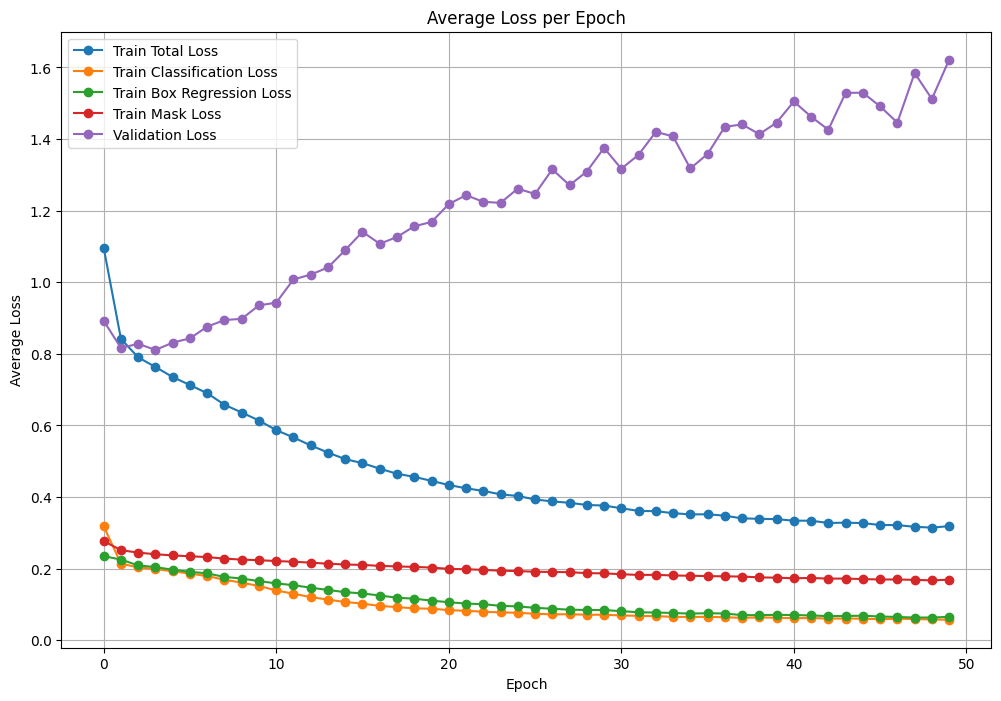

In [ ]:
#The plotted validation metric is not correct please ignore it

plt.figure(figsize=(12, 8))
plt.plot(train_total_losses, label='Train Total Loss', marker='o')
plt.plot(train_classification_losses, label='Train Classification Loss', marker='o')
plt.plot(train_box_losses, label='Train Box Regression Loss', marker='o')
plt.plot(train_mask_losses, label='Train Mask Loss', marker='o')  # If applicable
plt.plot(val_losses, label='Validation Loss', marker='o')

plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import cv2

In [ ]:
num_classes = 5

# Instantiate the model
model = get_model()

# Load the saved state dictionary
checkpoint = torch.load('/content/rcnn_epoch_40.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 137MB/s]


<All keys matched successfully>

In [ ]:
def predict_from_image_path(image_path, model, device, image_size, id_to_name, threshold=0.9):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize and normalize the image
    image_resized = cv2.resize(image_rgb, image_size, interpolation=cv2.INTER_LINEAR) / 255
    image_tensor = torch.as_tensor(image_resized, dtype=torch.float32)
    image_tensor = image_tensor.permute(2, 0, 1)  # Change to [C, H, W] format
    image_tensor = image_tensor.to(device)

    # Model prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        prediction = model([image_tensor])[0]

    # print("Scores:", prediction['scores'])
    # print("Labels:", prediction['labels'])
    # print("Boxes:", prediction['boxes'])

    image_plot = (image_resized * 255).astype(np.uint8)
    image_plot = cv2.cvtColor(image_plot, cv2.COLOR_RGB2BGR)

    for i in range(len(prediction['masks'])):
        mask = prediction['masks'][i, 0].detach().cpu().numpy()
        score = prediction['scores'][i].item()
        class_id = prediction['labels'][i].item()
        box = prediction['boxes'][i].detach().cpu().numpy().astype(int)

        if score > threshold:
            class_name = seq_to_name_map.get(class_id, "Unknown")
            label_text = f"{class_name}: {score:.2f}%"  # Combine class name and score

            # Draw bounding box and label text
            cv2.rectangle(image_plot, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
            cv2.putText(image_plot, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            mask_color = np.random.rand(3) * 255
            mask_indices = mask > 0.5
            image_plot[mask_indices] = image_plot[mask_indices] * 0.5 + mask_color * 0.5

    image_plot_rgb = cv2.cvtColor(image_plot, cv2.COLOR_BGR2RGB)
    plt.imshow(image_plot_rgb)
    plt.axis('off')
    plt.show()

    plt.imsave("pred.jpg", image_plot_rgb)


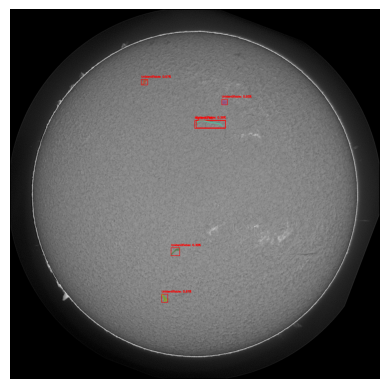

In [ ]:
predict_from_image_path("Data/test/images/20110205082634Lh_01.jpeg", model, DEVICE, IMAGE_SIZE, seq_to_name_map, threshold=0.2)

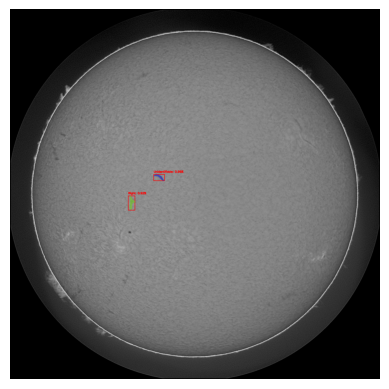

In [ ]:
predict_from_image_path("Data/test/images/20110520063154Uh_01.jpeg", model, DEVICE, IMAGE_SIZE, seq_to_name_map, threshold=0.9)

20110520063154Uh_01

4175458053 -- Ambiguous
813530507 -- Unidentifiable